In [1]:
import numpy as np

from rtlobs import collect as col
from rtlobs import utils as ut
from rtlobs import post_process as post

%matplotlib notebook

In [ ]:
# 8192 samples per call to the SDR
# 2048 bin resolution power spectral density estimate
# 49.6 dB of RtlSdr gain
# 2.32 MHz sample rate/bandwidth
# 1.420 GHz center frequency
# 10 sec integration time
ut.biast(1, index=0) # bias tee
f_on, p_on = col.run_spectrum_int(131072, 4096, 49.6, 2.32e6, 1.420e9, 30)
# Show the figure containing the plotted spectrum
fig, ax = post.plot_spectrum(f_on, p_on, savefig=None)#'../images/spectrum_int.png')

In [ ]:
ut.biast(1, index=0) # bias tee
# take a spectrum with the noise source turned on.
# the active gpio on the RTL-SDRblog v3 dongle should be connected to the
# nooelec SAWbird H1+ amp's Vcc pin.
ut.biast(1, index=0, gpio=5) # activate header pin 30
f_off, p_off = col.run_spectrum_int(131072, 4096, 49.6, 2.32e6, 1.420e9, 30)
fig, ax = post.plot_spectrum(f_off, p_off)
ut.biast(0, index=0, gpio=5)

In [ ]:
fig, ax = post.plot_spectrum(f_on,  p_on / p_off)

In [ ]:
f, p = col.run_fswitch_int(262144, 2048, 49.6, 2.048e6, 103.9e6, 104.3e6, 360., fswitch=1)
fig, ax = post.plot_spectrum(f, np.log10(p + 10))
# Edit figure labels to be technically correct
# ax.set_ylabel('Uncalibrated Power Estimate (V$^2$)')

In [ ]:
# make a sequence of freq-switched images

# ut.biast(1, index=0, gpio=0)

# num_pics = 10
# for i in range(num_pics):
#     time_str = time.strftime('%a, %d %b %Y %H:%M:%S', time.localtime(time.time()))
#     print(time_str)
#     f, p = col.run_fswitch_int(262144, 2048, 49.6, 2.048e6, 1420.3e6, 1420.7e6, 30., fswitch=1)
#     fig, ax = post.plot_spectrum(f, p)
#     # ax.set_ylim(-10e-8, 10e-8)
#     # Edit figure labels to be technically correct
#     ax.set_ylabel('Uncalibrated Power Estimate (V$^2$)')
#     ax.set_title(f'Power Spectrum Estimate\n{time_str}')
#     fig.savefig(f'../images/fswitch_int_{time_str}.png')
#     np.save(f'./output/fswitch_int_freqs_powers_{time_str}.npy', np.array([f, p]))
#     fig.show()

# ut.biast(0, index=0, gpio=0)

Enabling bias tee.
Found 1 device(s):
  0:  Realtek, RTL2838UHIDIR, SN: 1

Using device 0: Generic RTL2832U OEM
Found Rafael Micro R820T/2 tuner



<IPython.core.display.Javascript object>


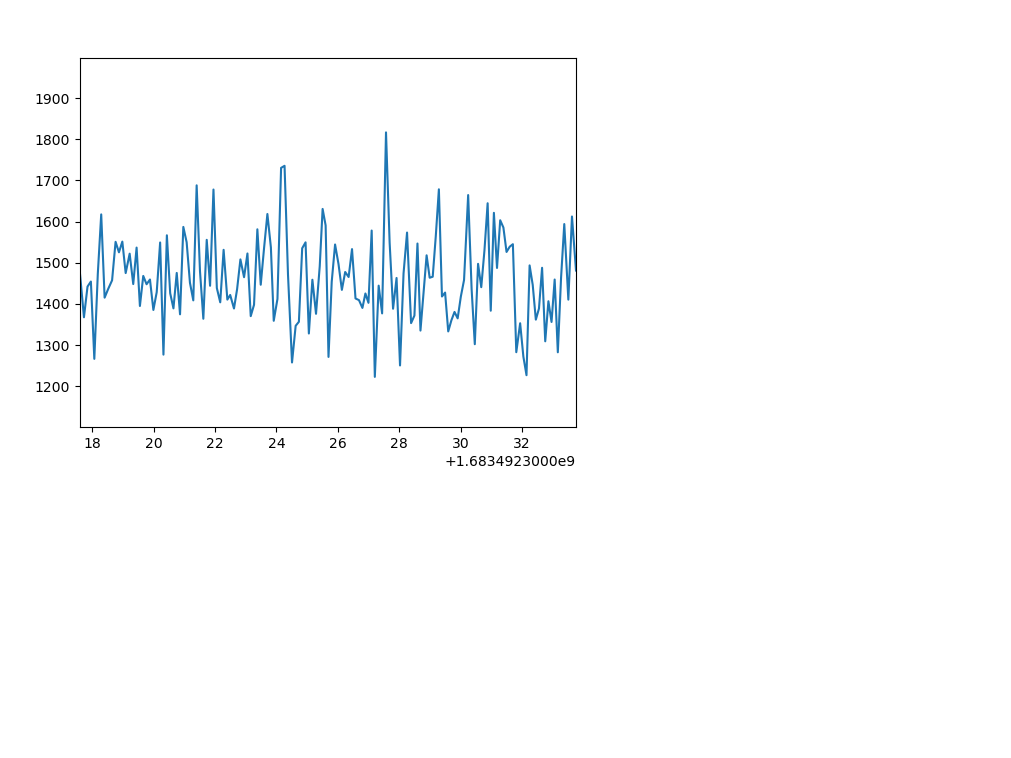

Found Rafael Micro R820T/2 tuner
/home/evanmayer/github/rtlobs/rtlobs/collect.py:206: UserWarning: Attempting to set identical left == right == 1683492314.0051668 results in singular transformations; automatically expanding.
  ax.set_xlim(np.min(t_interp[1:]), np.max(t_interp[1:]))


Disabling bias tee.
Found 1 device(s):
  0:  Realtek, RTL2838UHIDIR, SN: 1

Using device 0: Generic RTL2832U OEM
Found Rafael Micro R820T/2 tuner



In [37]:
import importlib
importlib.reload(col)

ut.biast(1, index=0, gpio=0)
col.dicke(262144//8, 36.0, 2.4e6, 1420.4e6, 300, plot=False)
ut.biast(0, index=0, gpio=0)

['/home/evanmayer/github/rtlobs/notebooks/dicke_timeseries_Sun, 07 May 2023 13:45:33.npy']


<IPython.core.display.Javascript object>


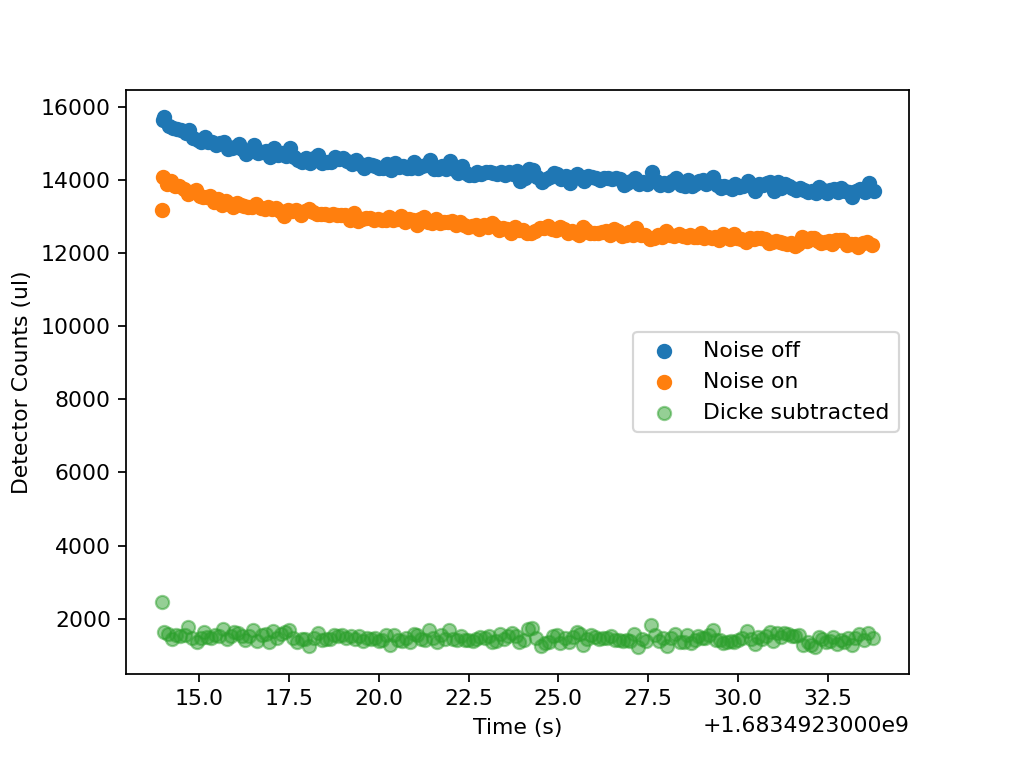

0.005406111191788919 0.04923343397880513


<IPython.core.display.Javascript object>


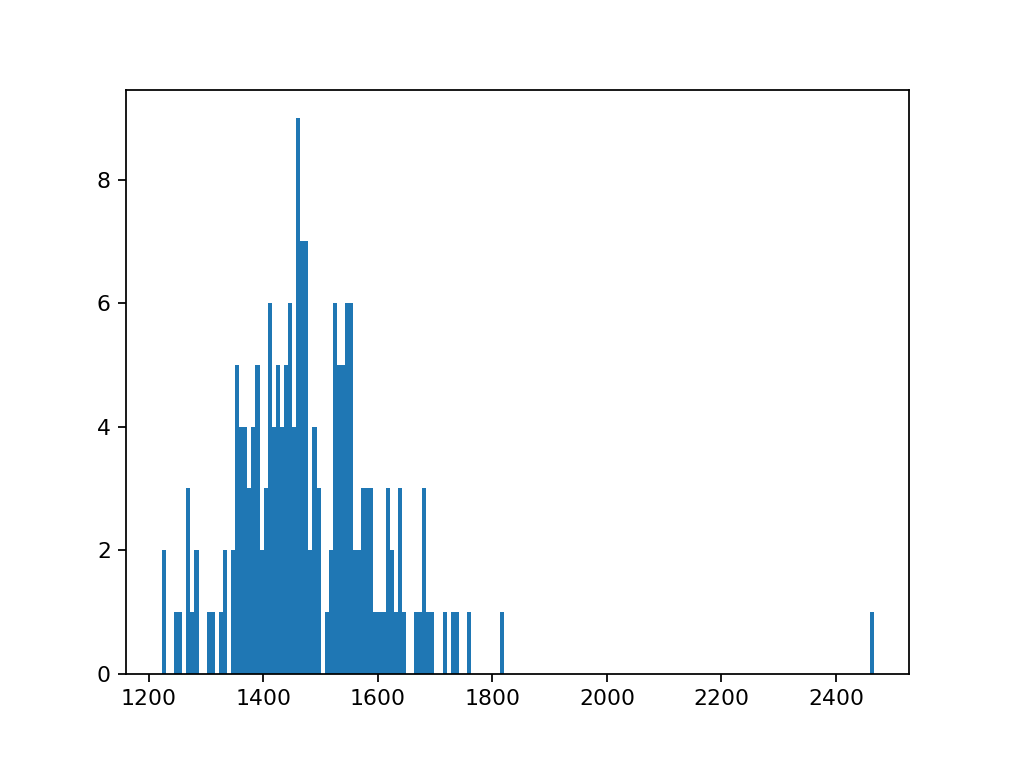

KstestResult(statistic=1.0, pvalue=0.0)

In [38]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm, kstest


%matplotlib widget


path = os.path.abspath('../notebooks/dicke*.npy')
pwr_files = sorted(glob(path, recursive=True))[-1:]
print(pwr_files)
assert pwr_files, f'No files found at {path}'
for i, file in enumerate(pwr_files):
    new_ts, new_ps, new_noise_on = np.load(file)
    if i == 0:
        ts = new_ts
        ps = new_ps
        noise_on = new_noise_on
    else:
        ts = np.concatenate([ts, new_ts])
        ps = np.concatenate([ps, new_ps])
        noise_on = np.concatenate([noise_on, new_noise_on])

ts = np.array(ts)
ps = np.array(ps)
noise_on = np.array(noise_on)

fig, ax = plt.subplots()
mask_off = np.where(noise_on < 1)[0]
mask_on = np.where(noise_on > 0)[0]

ax.scatter(
    ts[mask_off],
    ps[mask_off],
    label='Noise off'
)
ax.scatter(
    ts[mask_on],
    ps[mask_on],
    label='Noise on'
)
l = np.min((len(mask_on), len(mask_off)))
print(np.std(ts[mask_off][:l] - ts[mask_on][:l]), np.mean(ts[mask_off][:l] - ts[mask_on][:l]))
t_interp = [((ts[i] + ts[i-1]) / 2) for i in mask_off]
p_currs = [((ps[i] - ps[i-1])) for i in mask_off]
p_interp = p_currs
ax.scatter(
    t_interp,
    p_interp,
    alpha=0.5,
    label='Dicke subtracted'
)
ax.legend(loc='best')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Detector Counts (ul)')

fig, ax = plt.subplots()
ax.hist(p_interp, bins=175)

kstest(p_interp, norm.cdf)

In [ ]:
# test API
import time
from rtlsdr import RtlSdr

sdr = RtlSdr()

sdr.set_gpio_output(4)
sdr.set_gpio_bit(4, 0) # header 31
time.sleep(2)
sdr.set_gpio_bit(4, 1)
sdr.set_gpio_input(4)
print(sdr.get_gpio_bit(4))
time.sleep(2)
sdr.set_gpio_output(4)
sdr.set_gpio_bit(4, 0)
sdr.close()